<a href="https://colab.research.google.com/github/uesr-yu/uesr-yu.github.io/blob/master/OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
!git clone https://github.com/alfa-echo-niner-ait/loadlstm.git


Cloning into 'loadlstm'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 90 (delta 38), reused 73 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 3.62 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [4]:
%cd loadlstm


/content/loadlstm


In [5]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


In [6]:
!pip install tensorflow



# Dataset Preparation

Note that, all the data has been cleaned and prepared

In [7]:
# Power load dataset
load_dataset = pd.read_csv("data/load_data_clean.csv")
# Meterological dataset
met_dataset = pd.read_csv("data/met_data_clean.csv")
# Convert to Dataframe
load_df = pd.DataFrame(load_dataset)
met_df = pd.DataFrame(met_dataset)

In [8]:
load_df["DATE (MM/DD/YYYY)"] = pd.to_datetime(
    load_df["DATE (MM/DD/YYYY)"], format="%m/%d/%Y"
)

met_df["DATE (MM/DD/YYYY)"] = pd.to_datetime(
    met_df["DATE (MM/DD/YYYY)"], format="%m/%d/%Y"
)

In [9]:
load_df.head()

,DATE (MM/DD/YYYY),KW,KWS,CHWTON,HTmmBTU,Combined mmBTU,Combined Tons Carbon,KW#Houses,KWlightbulbs,KWgalsgas,...,CHWTONlightbulbs,CHWTONgalsgas,HTmmBTU#Houses,HTmmBTUlightbulbs,HTmmBTUgalsgas,Total#Houses,Totallightbulbs,Totalgalsgas,GHG,DOW
0,2024-05-01,351973.45,39367.64,117009.06,115.27,2720.37,497.21,100564,25140971,9608,...,29385656,11233,9652,2412510,922,227789,56939137,969870,169.754,4
1,2024-05-02,353826.38,39144.04,119220.71,115.03,2752.99,503.17,101093,25273323,9658,...,29941089,11445,9632,2407457,920,230520,57621868,987740,170.867,5
2,2024-05-03,357657.88,38935.34,123171.43,109.79,2808.22,513.27,102188,25547001,9763,...,30933274,11824,9193,2297666,878,235145,58777940,1019713,173.062,6
3,2024-05-04,363958.25,38676.54,118279.24,108.33,2769.56,506.20,103988,25997028,9935,...,29704649,11355,9071,2267263,867,231908,57968940,981181,176.630,7
4,2024-05-05,320144.95,33341.16,106070.52,108.39,2473.62,452.11,91470,22867506,8739,...,26638552,10183,9076,2268428,867,207127,51774485,879305,155.741,1


In [10]:
met_df.head()

,DATE (MM/DD/YYYY),AVG Air Temperature [deg F],MAX Air Temperature [deg F],MIN Air Temperature [deg F],AVG Rel Humidity [%],MAX Rel Humidity [%],MIN Rel Humidity [%],AVG Avg Wind Speed @ 3m [MPH],MAX Avg Wind Speed @ 3m [MPH],MIN Avg Wind Speed @ 3m [MPH],AVG Peak Wind Speed @ 3m [MPH],MAX Peak Wind Speed @ 3m [MPH],MIN Peak Wind Speed @ 3m [MPH],AVG Station Pressure [inHg],MAX Station Pressure [inHg],MIN Station Pressure [inHg]
0,2024-05-01,76.2268,87.494,61.322,19.3349,34.09,8.040,7.5972,24.4721,0.0,11.1715,30.6460,0.0,27.2098,27.2561,27.1436
1,2024-05-02,76.1305,89.690,60.836,18.6194,36.39,6.938,5.1366,22.8839,0.0,8.0311,27.2906,0.0,27.2407,27.2873,27.1868
2,2024-05-03,77.3261,89.960,63.878,19.7970,41.99,6.877,5.7147,23.8457,0.0,8.8923,39.0345,0.0,27.2277,27.2663,27.1653
3,2024-05-04,76.8995,89.762,61.106,17.8820,31.30,6.234,5.5733,20.5574,0.0,8.6903,25.6129,0.0,27.2277,27.2670,27.1798
4,2024-05-05,75.1771,86.774,63.176,18.5651,30.04,9.040,11.2813,32.4132,0.0,16.0872,44.0676,0.0,27.2212,27.2677,27.1493


In [11]:
# Join both dataset on Date
merged_df = pd.merge(load_df, met_df, on="DATE (MM/DD/YYYY)", how="inner")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   DATE (MM/DD/YYYY)               61 non-null     datetime64[ns]
 1   KW                              61 non-null     float64       
 2   KWS                             61 non-null     float64       
 3   CHWTON                          61 non-null     float64       
 4   HTmmBTU                         61 non-null     float64       
 5   Combined mmBTU                  61 non-null     float64       
 6   Combined Tons Carbon            61 non-null     float64       
 7   KW#Houses                       61 non-null     int64         
 8   KWlightbulbs                    61 non-null     int64         
 9   KWgalsgas                       61 non-null     int64         
 10  CHWTON#Houses                   61 non-null     int64         
 11  CHWTONli

In [12]:
# Corr. between columns with KW column
# corr_matrix = merged_df.corr()
# print(corr_matrix["KW"].sort_values(ascending=False))

# Dataset Processing

#### Step 1: Select relevant columns for normalization

In [13]:
features_to_normalize = [
    "KW",
    "GHG",
    "AVG Air Temperature [deg F]",
    "AVG Rel Humidity [%]",
    "AVG Avg Wind Speed @ 3m [MPH]",
]

In [14]:
model_df = merged_df[features_to_normalize]

In [15]:
corr_matrix = model_df.corr()
print(corr_matrix["KW"].sort_values(ascending=False))

KW                               1.000000
GHG                              0.986451
AVG Air Temperature [deg F]      0.446496
AVG Rel Humidity [%]             0.419901
AVG Avg Wind Speed @ 3m [MPH]   -0.276237
Name: KW, dtype: float64


In [16]:
cols = [
    "KW",
    "GHG",
    "AVG Temp",
    "AVG Humidity",
    "AVG Wind ",
]

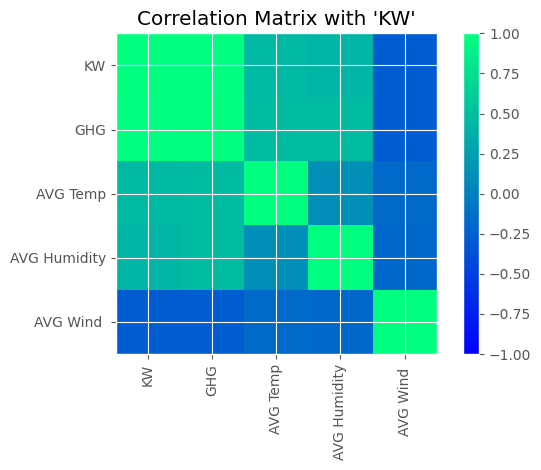

In [17]:
# Create the heatmap using Matplotlib
# plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="winter", vmin=-1, vmax=1)
plt.colorbar()

# Adding title
plt.title("Correlation Matrix with 'KW'")
# Set tick labels
plt.xticks(range(len(corr_matrix.columns)), cols, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), cols)

# Display the plot
plt.tight_layout()
plt.show()

**KW:**
   - **Description:** The total kilowatt (KW) power consumption for the day.
   - **Example:** `351973.45` KW represents the total power consumption on the given day.

**GHG:**
   - **Description:** Greenhouse gas emissions.
   - **Example:** `169.754` represents the greenhouse gas emissions.

**AVG Air Temperature [deg F]:**
   - **Description:** The average air temperature in degrees Fahrenheit for the day.
   - **Example:** `76.2268` degrees Fahrenheit.

**AVG Rel Humidity [%]:**
   - **Description:** The average relative humidity as a percentage for the day.
   - **Example:** `19.3349%`.

**AVG Avg Wind Speed @ 3m [MPH]:**
   - **Description:** The average wind speed at 3 meters above ground level in miles per hour for the day.
   - **Example:** `7.5972` miles per hour.

#### Step 2: Train-Test Split (80% training, 20% testing)

In [18]:
train_size = int(len(model_df) * 0.8)
train_data = model_df[:train_size]
test_data = model_df[train_size:]

In [19]:
scaler = MinMaxScaler()

In [20]:
train_scaled = train_data.copy()
train_scaled[features_to_normalize] = scaler.fit_transform(
    train_data[features_to_normalize]
)

test_scaled = test_data.copy()
test_scaled[features_to_normalize] = scaler.transform(test_data[features_to_normalize])

#### Step 3: Time Series Preparation (Create sliding window sequences)

In [21]:
sequence_length = 8  # Use past 8 days to predict the next day

def create_sequences(data, target_column, sequence_length):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]  # Sequence of 'n' days
        target = data[i + sequence_length][
            target_column + 1
        ]  # Target is the next day's load (KW)
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

Create sequences for training and testing sets

In [22]:
X_train, y_train = create_sequences(
    train_scaled[features_to_normalize].values,
    target_column=0,
    sequence_length=sequence_length,
)  # KW is the target
X_test, y_test = create_sequences(
    test_scaled[features_to_normalize].values,
    target_column=0,
    sequence_length=sequence_length,
)

# Print the shape of training and testing data
print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Testing data shape (X, y):", X_test.shape, y_test.shape)

Training data shape (X, y): (40, 8, 5) (40,)
Testing data shape (X, y): (5, 8, 5) (5,)


# Model Construction

#### Step 1: Convert data to PyTorch tensors

In [23]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

#### Step 2: Define the LSTM model

Define the LSTM model with L2 regularization

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_feature_map = lstm_out[:, -1, :]
        out = self.fc(final_feature_map)
        return out

In [25]:
# Initialize model, loss function, and optimizer with L2 regularization
input_dim = len(features_to_normalize)
hidden_dim = 64
output_dim = 1
dropout = 0.1

In [26]:
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers=4, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=0.0005, weight_decay=0.001
)  # Adding L2 regularization
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=20,
)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=7)

tensor(0.)

#### Step 3: Training loop

In [27]:
num_epochs = 80
batch_size = 32
patience = 20
best_loss = float("inf")
patience_counter = 0

In [28]:
# Create DataLoader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

In [29]:
# Keep track of loss
epoch_losses = list()
test_losses = list()

In [30]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = mean_squared_error(y_test_tensor, test_outputs.squeeze())
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss:.4f}")

Epoch [1/80], Loss: 0.4329
Test Loss: 0.2581
Epoch [2/80], Loss: 0.4061
Test Loss: 0.2348
Epoch [3/80], Loss: 0.3778
Test Loss: 0.2122
Epoch [4/80], Loss: 0.3524
Test Loss: 0.1899
Epoch [5/80], Loss: 0.3267
Test Loss: 0.1677
Epoch [6/80], Loss: 0.3001
Test Loss: 0.1449
Epoch [7/80], Loss: 0.2731
Test Loss: 0.1217
Epoch [8/80], Loss: 0.2444
Test Loss: 0.0978
Epoch [9/80], Loss: 0.2150
Test Loss: 0.0733
Epoch [10/80], Loss: 0.1826
Test Loss: 0.0490
Epoch [11/80], Loss: 0.1524
Test Loss: 0.0274
Epoch [12/80], Loss: 0.1200
Test Loss: 0.0130
Epoch [13/80], Loss: 0.0878
Test Loss: 0.0130
Epoch [14/80], Loss: 0.0735
Test Loss: 0.0348
Epoch [15/80], Loss: 0.0695
Test Loss: 0.0649
Epoch [16/80], Loss: 0.0791
Test Loss: 0.0764
Epoch [17/80], Loss: 0.0841
Test Loss: 0.0660
Epoch [18/80], Loss: 0.0789
Test Loss: 0.0469
Epoch [19/80], Loss: 0.0727
Test Loss: 0.0302
Epoch [20/80], Loss: 0.0709
Test Loss: 0.0213
Epoch [21/80], Loss: 0.0677
Test Loss: 0.0172
Epoch [22/80], Loss: 0.0689
Test Loss: 0.01

#### Step 4: Check Training Process

In [31]:
# Loss value tracking
print(f"Epoch\t\tMin: {min(epoch_losses):.4f}\t Max: {max(epoch_losses):.4f}")
print(f"Test\t\tMin: {min(test_losses):.4f}\t Max: {max(test_losses):.4f}")

Epoch		Min: 0.0624	 Max: 0.4329
Test		Min: 0.0094	 Max: 0.2581


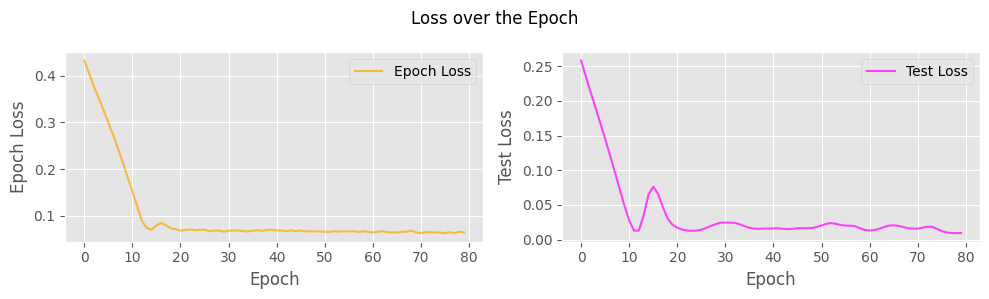

In [32]:
# Plot training & validation loss values
plt.figure(figsize=(10, 3))
plt.suptitle("Loss over the Epoch")

plt.subplot(1, 2, 1)
plt.plot(np.array(epoch_losses), color="orange", alpha=0.7)
plt.ylabel("Epoch Loss")
plt.xlabel("Epoch")
plt.legend(["Epoch Loss"], loc="upper right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.array(test_losses), color="magenta", alpha=0.7)
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(["Test Loss"], loc="upper right")
plt.grid(True)
plt.tight_layout()

plt.show()

# Model Evaluation

In [33]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [35]:
print(X_test_tensor)


tensor([[[ 0.7825,  0.7677,  0.7931,  0.5061,  0.5475],
         [ 0.8185,  0.8025,  0.8591,  0.7776,  0.2969],
         [ 1.0124,  1.0314,  0.9162,  1.2711,  0.3024],
         [ 1.2990,  1.2891,  0.8836,  2.0647,  0.4810],
         [ 1.2830,  1.4737,  0.5366,  4.1951, -0.0550],
         [ 1.2313,  1.3272,  0.6981,  3.7691,  0.1572],
         [ 1.5695,  1.5662,  0.7915,  2.8395,  0.0370],
         [ 1.0011,  1.1202,  0.7858,  2.9487,  0.1869]],

        [[ 0.8185,  0.8025,  0.8591,  0.7776,  0.2969],
         [ 1.0124,  1.0314,  0.9162,  1.2711,  0.3024],
         [ 1.2990,  1.2891,  0.8836,  2.0647,  0.4810],
         [ 1.2830,  1.4737,  0.5366,  4.1951, -0.0550],
         [ 1.2313,  1.3272,  0.6981,  3.7691,  0.1572],
         [ 1.5695,  1.5662,  0.7915,  2.8395,  0.0370],
         [ 1.0011,  1.1202,  0.7858,  2.9487,  0.1869],
         [ 0.5556,  0.5637,  0.9427,  2.2362,  0.5225]],

        [[ 1.0124,  1.0314,  0.9162,  1.2711,  0.3024],
         [ 1.2990,  1.2891,  0.8836,  2.0647

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [39]:
model.to(device)


LSTMModel(
  (lstm): LSTM(5, 64, num_layers=4, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [40]:
X_test_tensor = X_test_tensor.to(device)


In [41]:
# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))

# Move predictions and actual values to CPU and detach them from the computation graph
y_pred = y_pred.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().numpy()

In [42]:
# Inverse transform the predictions and actual values
y_pred_inverse = scaler.inverse_transform(
    np.concatenate(
        [y_pred, np.zeros((y_pred.shape[0], len(features_to_normalize) - 1))], axis=1
    )
)[
    :, 0
]  # Only reverse the first column which is KW

y_test_inverse = scaler.inverse_transform(
    np.concatenate(
        [
            y_test_np.reshape(-1, 1),
            np.zeros((y_test_np.shape[0], len(features_to_normalize) - 1)),
        ],
        axis=1,
    )
)[
    :, 0
]  # Only reverse the first column which is KW

In [43]:
# Define MAPE and RMSE functions
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate MAPE and RMSE
mape_value = MAPE(y_test_inverse, y_pred_inverse)
rmse_value = RMSE(y_test_inverse, y_pred_inverse)

print(f"MAPE: {mape_value:.2f}%")
print(f"RMSE: {rmse_value:.2f} KW")

MAPE: 2.15%
RMSE: 9676.61 KW


In [44]:
print("Actual:\t\t", end="")
for val in y_test_inverse:
    print(f"{val:.2f}", end="\t")
print()
print("Predicted:\t", end="")
for val in y_pred_inverse:
    print(f"{val:.2f}", end="\t")
print(
    "\n-----------------------------------------------------------------------------------------"
)
print("Difference:\t", end="")
for val in y_test_inverse - y_pred_inverse:
    print(f"{val:.2f}", end="\t")

Actual:		344308.41	346086.61	318328.18	341616.68	334400.75	
Predicted:	341244.19	339593.10	338099.92	336679.76	335555.74	
-----------------------------------------------------------------------------------------
Difference:	3064.21	6493.51	-19771.73	4936.92	-1154.98	

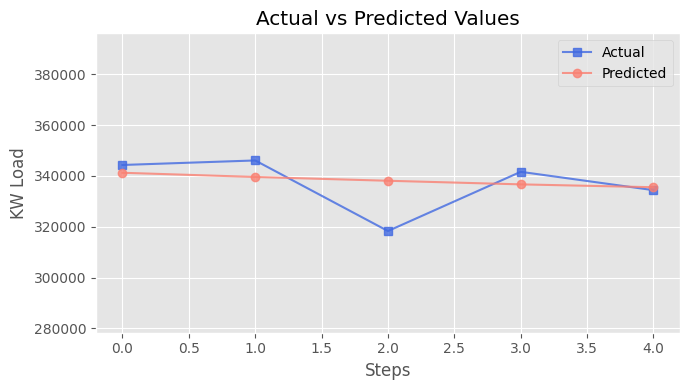

In [45]:
# Adjusting the plot to better center the data for a cleaner look
plt.figure(figsize=(7, 4))
# Plot actual values
plt.plot(y_test_inverse, label="Actual", marker="s", linestyle="-", color="royalblue", alpha=0.8)
# Plot predicted values
plt.plot(
    y_pred_inverse, label="Predicted", marker="o", linestyle="-", color="salmon", alpha=0.8
)
# Title and labels
plt.title("Actual vs Predicted Values")
plt.xlabel("Steps")
plt.ylabel("KW Load")
# Show legend
plt.legend()
# Adjusting the y-limits to center the data and avoid awkward spacing
y_min = min(min(y_test_inverse), min(y_pred_inverse)) - 40000
y_max = max(max(y_test_inverse), max(y_pred_inverse)) + 50000
plt.ylim([y_min, y_max])
# Display the plot with gridlines and tighter layout
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Save the Model
torch.save(model.state_dict(), "final_lstm_model.pth")